# OLS regressions - baseline for Capstone analysis
In this notebook, I perform OLS regressions using DC to DC CaBi trips as the dependent variable.

In [1]:
from util_functions import *
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('darkgrid')
import statsmodels.graphics.gofplots as gofplots
%matplotlib inline

set_env_path()
conn, cur = aws_connect()
query = """
SELECT *,
CASE day_of_week WHEN 5 THEN 1 WHEN 6 THEN 1 ELSE 0 END AS weekend_dummy
from final_db
"""
df = pd.read_sql(query, con=conn)
df.shape

(2750, 834)

### First specification attempt - theory based

In [2]:
def fitOLS(equation, cov='nonrobust'):
    '''
    This function uses statsmodels.ols to estimate OLS regressions using R/patsy-style syntax.
    
    Args:
        equation (str): A patsy-style regression equation.
                        e.g. 'cabi_trips ~ apparenttemperaturehigh + daylight_hours + rain'
        cov      (str): A specific covariance matrix type. Default is 'nonrobust'. 
                        HC0-HC3 available for heteroskedasticity-robust standard errors.
    Returns:
        results: A RegressionResults object which summarizes the fit of a linear regression model.
    '''
    model = smf.ols('{}'.format(equation), df)
    results = model.fit(cov_type='{}'.format(cov), use_t=True)
    return results

We know that a lot of trips depend on weather, but we should be careful to avoid multicollinearity. X below contains all of the variables in question.

In [4]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
X = df[['cabi_trips', 'cabi_trips_casual', 'cabi_trips_member',
        'cabi_trips_wdc_to_wdc', 'cabi_trips_wdc_to_wdc_member',
        'cabi_trip_dur_avg_casual', 'cabi_trip_dur_avg_member',
        'cabi_trip_dist_avg_casual', 'cabi_trip_dist_avg_member',
        'cabi_bikes_avail', 'cabi_stations_wdc', 'cabi_docks_wdc',
        'cabi_dur_empty_wdc', 'cabi_dur_full_wdc', 'cabi_util_rate',
        'cabi_active_members_monthly', 'dless_trips_all', 'dless_tripdist_avg_all',
        'date', 'dc_pop', 'quarter', 'month', 'daylight_hours', 
        'apparenttemperaturehigh', 'apparenttemperaturelow',
        'apparenttemperaturehightime', 'cloudcover', 'humidity',
        'rain', 'snow', 'nats_single', 'nats_double', 
        'us_holiday', 'dc_bike_event', 'day_of_week']]
X.describe().round(0).transpose()

,count,mean,std,min,25%,50%,75%,max
cabi_trips,2750.0,7166.0,3742.0,0.0,4220.0,6868.0,10331.0,16896.0
cabi_trips_casual,2750.0,1552.0,1519.0,0.0,424.0,1083.0,2192.0,10173.0
cabi_trips_member,2750.0,5614.0,2768.0,0.0,3519.0,5586.0,7646.0,11848.0
cabi_trips_wdc_to_wdc,2750.0,6341.0,3174.0,0.0,3882.0,6190.0,9041.0,14964.0
cabi_trips_wdc_to_wdc_member,2750.0,4959.0,2317.0,0.0,3252.0,4982.0,6755.0,9979.0
cabi_trip_dur_avg_casual,2750.0,2246.0,495.0,0.0,1983.0,2257.0,2515.0,7085.0
cabi_trip_dur_avg_member,2750.0,714.0,86.0,0.0,662.0,708.0,756.0,1272.0
cabi_trip_dist_avg_casual,2750.0,1748.0,149.0,0.0,1679.0,1748.0,1824.0,2863.0
cabi_trip_dist_avg_member,2750.0,1774.0,124.0,0.0,1720.0,1796.0,1849.0,2238.0
cabi_bikes_avail,2750.0,2841.0,1255.0,97.0,1658.0,3115.0,3900.0,4612.0


In [5]:
X.corr().round(3)

,cabi_trips,cabi_trips_casual,cabi_trips_member,cabi_trips_wdc_to_wdc,cabi_trips_wdc_to_wdc_member,cabi_trip_dur_avg_casual,cabi_trip_dur_avg_member,cabi_trip_dist_avg_casual,cabi_trip_dist_avg_member,cabi_bikes_avail,cabi_stations_wdc,cabi_docks_wdc,cabi_dur_empty_wdc,cabi_dur_full_wdc,cabi_util_rate,cabi_active_members_monthly,dless_trips_all,dless_tripdist_avg_all,dc_pop,quarter,month,daylight_hours,apparenttemperaturehigh,apparenttemperaturelow,apparenttemperaturehightime,cloudcover,humidity,rain,snow,nats_single,nats_double,us_holiday,dc_bike_event,day_of_week
cabi_trips,1.000,0.761,0.934,0.999,0.933,0.163,0.368,0.142,0.495,0.634,0.617,0.616,0.856,0.753,0.477,0.678,0.127,0.102,0.624,0.119,0.112,0.503,0.584,0.549,0.184,-0.429,-0.001,-0.076,-0.243,0.274,0.046,-0.098,0.052,0.044
cabi_trips_casual,0.761,1.000,0.480,0.768,0.480,0.357,0.546,0.154,0.284,0.417,0.391,0.392,0.499,0.313,0.410,0.576,0.022,0.021,0.393,0.078,0.063,0.499,0.529,0.499,0.188,-0.323,-0.013,-0.084,-0.193,0.308,0.073,0.028,0.078,0.048
cabi_trips_member,0.934,0.480,1.000,0.929,0.998,0.024,0.199,0.107,0.513,0.628,0.619,0.617,0.884,0.846,0.419,0.600,0.159,0.127,0.628,0.119,0.117,0.406,0.499,0.468,0.145,-0.403,0.005,-0.057,-0.222,0.201,0.022,-0.147,0.028,0.033
cabi_trips_wdc_to_wdc,0.999,0.768,0.929,1.000,0.930,0.170,0.376,0.146,0.505,0.613,0.598,0.597,0.843,0.742,0.505,0.682,0.117,0.091,0.604,0.119,0.111,0.515,0.595,0.559,0.191,-0.429,-0.005,-0.075,-0.249,0.281,0.048,-0.102,0.052,0.050
cabi_trips_wdc_to_wdc_member,0.933,0.480,0.998,0.930,1.000,0.026,0.203,0.116,0.528,0.605,0.599,0.597,0.871,0.839,0.451,0.603,0.149,0.115,0.607,0.117,0.115,0.416,0.509,0.477,0.152,-0.403,0.000,-0.056,-0.229,0.207,0.024,-0.154,0.027,0.039
cabi_trip_dur_avg_casual,0.163,0.357,0.024,0.170,0.026,1.000,0.660,0.130,0.324,-0.156,-0.197,-0.197,0.041,0.016,0.381,0.288,-0.096,-0.112,-0.175,0.076,0.069,0.332,0.427,0.377,0.221,-0.159,-0.068,-0.034,-0.234,0.184,0.042,0.094,0.006,0.021
cabi_trip_dur_avg_member,0.368,0.546,0.199,0.376,0.203,0.660,1.000,0.291,0.583,-0.059,-0.099,-0.097,0.239,0.203,0.546,0.451,-0.001,-0.007,-0.079,0.102,0.098,0.472,0.558,0.506,0.233,-0.172,-0.009,-0.036,-0.247,0.271,0.056,0.044,0.028,0.036
cabi_trip_dist_avg_casual,0.142,0.154,0.107,0.146,0.116,0.130,0.291,1.000,0.401,-0.035,-0.036,-0.035,0.069,0.064,0.204,0.030,0.003,-0.020,-0.045,0.037,0.042,-0.001,0.015,-0.002,0.004,-0.008,-0.064,-0.062,-0.050,0.013,0.018,-0.052,0.018,0.112
cabi_trip_dist_avg_member,0.495,0.284,0.513,0.505,0.528,0.324,0.583,0.401,1.000,-0.053,-0.073,-0.070,0.434,0.481,0.673,0.452,-0.074,-0.120,-0.056,0.099,0.099,0.443,0.541,0.504,0.187,-0.110,0.014,0.047,-0.352,0.211,0.026,-0.107,-0.005,-0.003
cabi_bikes_avail,0.634,0.417,0.628,0.613,0.605,-0.156,-0.059,-0.035,-0.053,1.000,0.987,0.983,0.622,0.503,-0.286,0.283,0.295,0.323,0.985,-0.016,-0.012,0.038,0.024,0.022,-0.063,-0.351,0.045,-0.051,0.004,0.011,0.004,-0.005,0.072,0.002


From here, we can pare down the variables further.
We are mainly interested in cabi_trips_wdc_to_wdc, so we can drop a lot of CaBi variables that are highly correlated with our dependent variable.
dc_pop is highly correlated with CaBi bikes, stations, and docks, as well as year.

In [6]:
#corr = X.corr()
#sns.heatmap(corr)
X0 = X[['cabi_trips_wdc_to_wdc', 'cabi_dur_empty_wdc', 'cabi_dur_full_wdc', 
        'cabi_util_rate', 'cabi_active_members_monthly', 'dless_trips_all',
        'dc_pop', 'daylight_hours', 'apparenttemperaturehigh', 'cloudcover']]
print(X0.corr().round(3))

                             cabi_trips_wdc_to_wdc  cabi_dur_empty_wdc  \
cabi_trips_wdc_to_wdc                        1.000               0.843   
cabi_dur_empty_wdc                           0.843               1.000   
cabi_dur_full_wdc                            0.742               0.840   
cabi_util_rate                               0.505               0.323   
cabi_active_members_monthly                  0.682               0.557   
dless_trips_all                              0.117               0.236   
dc_pop                                       0.604               0.607   
daylight_hours                               0.515               0.389   
apparenttemperaturehigh                      0.595               0.494   
cloudcover                                  -0.429              -0.345   

                             cabi_dur_full_wdc  cabi_util_rate  \
cabi_trips_wdc_to_wdc                    0.742           0.505   
cabi_dur_empty_wdc                       0.840       

Next I drop some correlated X variables and run the regression.

After expanding the specification, day of week didn't reflect the data so I dropped it.

In [8]:
results = fitOLS('cabi_trips_wdc_to_wdc ~ '
                 'cabi_active_members_monthly + dc_pop + quarter + '
                 'apparenttemperaturehigh*snow + '
                 'rain + cloudcover + nats_single + '
                 'nats_double + us_holiday', cov='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     cabi_trips_wdc_to_wdc   R-squared:                       0.779
Model:                               OLS   Adj. R-squared:                  0.778
Method:                    Least Squares   F-statistic:                     1097.
Date:                   Tue, 15 May 2018   Prob (F-statistic):               0.00
Time:                           18:27:27   Log-Likelihood:                -24002.
No. Observations:                   2750   AIC:                         4.803e+04
Df Residuals:                       2738   BIC:                         4.810e+04
Df Model:                             11                                         
Covariance Type:                     HC0                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -3.737e+04    885.622    -42.195      0.000   -3.91e+04   -3.56e+04
cabi_active_members_monthly      5.4580      0.394     13.870      0.000       4.686       6.230
dc_pop                           0.0598      0.001     45.730      0.000       0.057       0.062
quarter                         52.5221     26.462      1.985      0.047       0.634     104.410
apparenttemperaturehigh         57.3109      2.744     20.887      0.000      51.931      62.691
snow                         -1456.1964    466.202     -3.124      0.002   -2370.339    -542.054
apparenttemperaturehigh:snow    11.9336     16.791      0.711      0.477     -20.991      44.858
rain                          -744.1829     67.506    -11.024      0.000    -876.550    -611.816
cloudcover                   -1529.2402    146.769    -10.419      0.000   -1817.029   -1241.451
nats_single                    338.1030     82.692      4.089      0.000     175.958     500.248
nats_double                    764.3737    308.985      2.474      0.013     158.507    1370.241
us_holiday                   -1221.2469    203.347     -6.006      0.000   -1619.975    -822.519
==============================================================================
Omnibus:                      100.087   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.941
Skew:                          -0.343   Prob(JB):                     1.67e-33
Kurtosis:                       3.920   Cond. No.                     2.05e+07
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 2.05e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our Rsquared is 0.78 which is pretty high. Everything except for the temperature/snow interaction term isstatistically significant, which implies that the effect of snow is the same at all levels of apparenttemperaturehigh.

The positive coefficients on monthly active members and DC population make intuitive sense. More members and more people means more bike rides.

The weather variables also make sense. Snowy, cloudy, rainy, and cold days are unpleasant for biking. 

The Nats related variable coefficients show that Nationals games are a huge driver of CaBi use. The us_holiday coefficient makes sense since most DC cabi riders are members, who are more likely to be out of town on holidays.

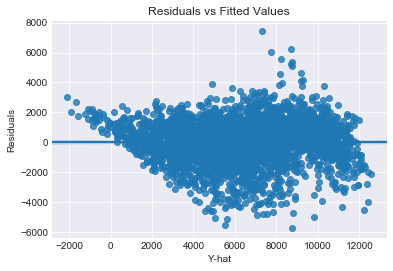

In [9]:
'''Homoskedasticity is when the variance/scatter/spread of the residuals is 
constant for all values of the fitted values. It is an assumption under OLS.

Heteroskedasticity is when the variance of the residuals changes as the fitted values change.
If not addressed, it can lead to biased estimators.
If our residuals were heteroskedastic, we would expect a scatter plot to form a funnel shape,
and a regression line to have a slope.
'''

# Regplot fits a regression line to a scatterplot
plt.title('Residuals vs Fitted Values')
sns.regplot(results.fittedvalues, results.resid)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

It doesn't look like there's heteroskedasticity, and the regression line is flat. However I think given our sample size and the significance of our variables, it couldn't hurt to specify heteroskedasticity-robust standard errors (the cov=HC0 argument in fitOLS). 

In practice I rarely see standard errors that aren't robust to either heteroskedasticity or clustering. (If we wanted to cluster, we would have to choose variables to cluster on, and I haven't looked into that for our data).

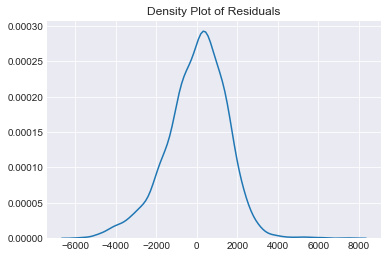

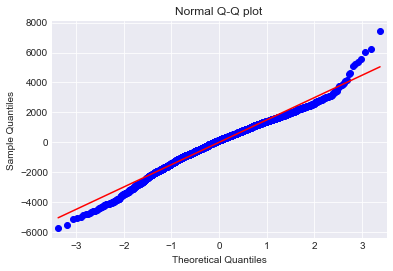

In [10]:
'''Normality of the residuals with mean 0 is another assumption under OLS.
If residuals are nonnormal and not approximately centered at 0, the model is probably misspecified.
The first chart is a kernel density estimation and the second is a Q-Q plot.

Q-Q plots compare two datasets to see whether or not they come from the same distribution.
If they do, the points should form a straight line.
Here, we have a Normal Q-Q plot, where our residuals are being compared against a normal distribution.
'''

# How are our residuals distributed?
plt.title('Density Plot of Residuals')
sns.kdeplot(results.resid)
plt.show()

# How close are our residuals to normal?
fig = gofplots.qqplot(results.resid, line='s')
plt.title("Normal Q-Q plot")
plt.show()

The residuals appear to be somewhat close to 0.

The third chart shows that our residuals are close to normal, but at the extreme ends of our distribution we get farther from a normal distribution.